#  ArcGIS API for Python: Assess burn scars after wildfires with ArcGIS Notebooks

In this notebook, you'll use ArcGIS API for Python to identify burn scars after two wildfires in Glacier National Park in Montana. You'll select satellite images before and after two wildfires, apply the normalized burn ratio (NBR) index to each image, and compute the difference to visualize the burn scars. You'll also learn about the short-wave infrared with dynamic range adjustment (DRA) rendering, how to symbolize a raster with a color ramp, and how to create your own area of interest polygon. 

**Note:** This is the second notebook in the [Analyze imagery with ArcGIS Notebooks](https://learn.arcgis.com/en/paths/analyze-imagery-with-arcgis-notebooks/) learning path. For an optimal experience, consider doing all four notebooks in the order proposed.

This notebook was last tested on December 3, 2024.

## Table of contents

* [Introduction](#introduction)
* [Set up the environment](#environment)
* [Get the data](#data)
* [Visualize and explore the imagery](#visualize)
* [Perform the analysis](#analysis)
* [Summary](#summary)
* [Stretch goal](#stretch)
* [Acknowledgments](#acknowledgments)




## Introduction <a class="anchor" id="introduction"></a>

In the summer of 2015, wildfires raged through Glacier National Park in Montana. Following fires such as these, it is critical for forest management services to measure the burn scars, as they will serve as a baseline to monitor forest regeneration. As the imagery analyst, you'll use Landsat satellite images from before and after the fires to identify the burn scars.


## Set up the environment <a class="anchor" id="environment"></a>

First, you need to import the Python modules and functions that you'll use in this notebook and that are not part of Python's default installation. Importing objects and functions makes them available for your code.

1. Run the cell below to import the required objects and function.

In [ ]:
# Import GIS from the arcgis package - this will allow you to create a GIS object to connect to ArcGIS Online.
from arcgis import GIS

# Import the ImageryLayer class from the arcgis.raster module so you can create imagery layer objects.
from arcgis.raster import ImageryLayer

# Import the apply, clip, nbr, and stretch functions from arcgis.raster.functions so you can apply
# them to the imagery layers.
from arcgis.raster.functions import apply, clip, nbr, stretch

# Import the polygon class from arcgis.geometry so you can make polygon objects.
from arcgis.geometry import Polygon

# Import the within function from arcgis.geometry.filters so you can filter by the polygon geometry.
from arcgis.geometry.filters import within

# Import the datetime module so you can create datetime objects to filter imagery by date.
import datetime as dt

# Import the HBox widget from the ipywidgets module so you can compare two maps arranged horizontally beside each other.
from ipywidgets import HBox

**Tip:** If your notebook remains idle too long at any point in this workflow, it might time out. If that happens or any step takes longer than a couple of minutes to run, you should restart the kernel: on the Notebook's ribbon, click **Kernel** and **Restart**. Then run the cells again from the beginning of the notebook.

Next, you'll create an anonymous connection to ArcGIS Online.  

2. Run the cell below to create the connection.

In [ ]:
# Create the variable gis to hold an anonymous connection to ArcGIS Online.
gis = GIS()

## Get the data <a class="anchor" id="data"></a>

### Create an imagery layer instance

You will use Landsat satellite imagery. You'll create an **ImageryLayer** instance from the [Multispectral Landsat image service](https://www.arcgis.com/home/item.html?id=d9b466d6a9e647ce8d1dd5fe12eb434b), hosted in [ArcGIS Living Atlas of the World](https://livingatlas.arcgis.com/en/home/).

3. Run the cell below to create the imagery layer instance.

In [ ]:
# Create a variable called landsat_imagery that is an ImageryLayer object, 
# getting its images from the online Multispectral Landsat image service.
landsat_imagery = ImageryLayer("https://landsat2.arcgis.com/arcgis/rest/services/Landsat/MS/ImageServer")

# Draw the imagery layer.
landsat_imagery

### Define your area of interest

Next, to focus the workflow on the right location, you'll define your area of interest (AOI) in the part of Glacier National Park where the fires took place.  

The AOI will be a rectangular [polygon](https://developers.arcgis.com/python/guide/part2-working-with-geometries/#Creating-Polygon-objects) defined by coordinates in the [WGS84 coordinate system](https://developers.arcgis.com/documentation/spatial-references/#4326---gps).

4. Run the cell below to create a polygon object from a list of coordinates.

In [ ]:
# Create a polygon object from a list of five coordinates (expressed as five longitude and latitude pairs)
# representing the polygon's corners. The last one is at the same location as the first to close 
# the polygon.
wild_fires_aoi = Polygon({"rings": [[[-113.77754932351269,48.751093840355502],
                                 [-113.77754932351269,48.489177416955975],
                                 [-113.32190203534647,48.489177416955975],
                                 [-113.32190203534647,48.751093840355502],
                                 [-113.77754932351269,48.751093840355502]]],
                       "spatialReference": {"wkid": 4326}})

# The spatial reference of the polygon is set using the well-known ID or "wkid" code of 4326, 
# which corresponds to WGS84.

5. Run the cell below to view the polygon in a map.

In [ ]:
# Create a variable called map that is an instance of the gis.map class.
map1 = gis.map()

# Draw the wild_fires_aoi polygon object on the map.
map1.draw(wild_fires_aoi)

# Set the extent of the map to the envelope of the feature.
map1.extent = dict(wild_fires_aoi.envelope)

# Draw the map.
map1

The AOI is located in Glacier National Park, which comprises more than 1 million acres, and is centered on the area where the two 2015 fires took place.

### Select specific Landsat scenes

Next, you need to select specific images (or scenes) captured shortly before and shortly after the two 2015 wildfires, as your goal is to compare the imagery and see what has changed. In both cases, you want to select a scene captured during the summer, when trees have leaves, to better contrast with burnt areas.

First, you'll select the Landsat scene captured before the fires. Using the **filter_by** function, you'll find all the scenes in the Landsat service that contain the AOI and were captured during the leaf-on season of 2014.  

6. Run the cell below to filter the Landsat scenes.

In [ ]:
# Create a variable called selected_before that contains all the scenes that were captured 
# in the desired time range and contain the AOI (that is, the AOI must be "within" the scenes).
selected_before = landsat_imagery.filter_by(time=[dt.datetime(2014, 6, 1), dt.datetime(2014, 9, 15)], geometry=within(wild_fires_aoi))


Then, using the **query** function, you'll order scenes selected by cloud cover and keep only the first one (that is, the one with the least cloud cover). You'll also specify the property fields that you want to display. 

The result will be a 1-record [spatial dataframe](https://developers.arcgis.com/python/guide/introduction-to-the-spatially-enabled-dataframe/) (**sdf**), a convenient object to store geospatial data. You'll display that record.

**Note:** Imaging satellites orbit far beyond the Earth’s atmosphere, so if clouds are present, they will appear in the scene captured, and obscure the Earth’s surface. The percentage of the scene obscured by cloud cover is a metadata field stored with every dataset, and this field can be used as a filter to find the scene with the least amount of cloud cover in the targeted date range.

7. Run the cell below to get the scene with the least cloud cover and to display it as a data frame.

In [ ]:
# Create a data frame showing the one record with the least cloud cover.
df_before = selected_before.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                    order_by_fields="CloudCover",
                    result_record_count=1).sdf

# Display the data frame.
df_before

Within the 6/1/2014 to 9/15/2014 time range, the scene captured on 9/5/2014 contains the least cloud cover (0.61%), which is essentially cloud-free.

You'll put the scene selected in a variable, referring to it by its **OBJECTID** attribute. This will enable easy access to it in the rest of the notebook.  

8. Run the cell below to create a variable containing the scene referenced by **OBJECTID**.

In [ ]:
# Create a variable containing the scene referenced by OBJECTID.
selected_scene_before = landsat_imagery.filter_by(f"OBJECTID={df_before.iloc[0]['OBJECTID']}")

To verify whether the extent of the image is appropriate, you'll display the image selected in its default rendering along with the AOI polygon.  

9. Run the cell below to create a second map, add the layer and the AOI to it, and draw the map.

In [ ]:
# Create a map object.
map2 = gis.map()

# Add the selected_before layer.
map2.add_layer(selected_scene_before)  

# Add the AOI polygon to the map.
map2.draw(wild_fires_aoi)

# Set the extent of the map to the envelope of the AOI polygon.
map2.extent = dict(wild_fires_aoi.envelope)

# Draw the map.
map2

The AOI polygon is displayed on top of the selected image.  

**Tip:** If the polygon does not display on top of the image, try running the previous cell one more time.

10. On the map, zoom out until you see the entire image. 

The scene contains the entire AOI, which means that the extent of the image is satisfactory. By default, the Multispectral Landsat image service you are using in this notebook is rendered with the Agriculture with DRA band combination (bands SWIR1, NIR, and Blue or 6,5,2), which displays vegetation in vivid green, bare earth in orange brown, water in bluish black, and snow in turquoise blue. DRA, which stands for dynamic range adjustment is a technique to improve the contrast of the image. With DRA, the contrast is adjusted based on the pixel values in the current display extent, instead of taking into account all the pixels in the entire raster dataset.


Following the same method, you'll select a Landsat scene captured just after the two 2015 fires. The Reynolds Creek fire was at its height around July 22 and the Thompson fire around Aug 12. So you'll choose the date range from 8/20/2015 to 9/15/2015, targeting again the leaf-on season only.

11. Run the cell below to select the scene after the second fire.

In [ ]:
# Create a variable called selected_after that contains all the scenes that were captured  
# in the desired time range and contain the AOI.
selected_after = landsat_imagery.filter_by(time=[dt.datetime(2015, 8, 20), dt.datetime(2015, 9, 15)],
                               geometry=within(wild_fires_aoi))

# Create a data frame showing the one record with the least cloud cover.
df_after = selected_after.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                    order_by_fields="CloudCover",
                    result_record_count=1).sdf

# Show the dataframe.
df_after


The new scene selected has a suitable **AcquisitionDate** value (08/23/2015) and a low **CloudCover** percentage (1.88 percent).  

12. Run the cell below to create a variable containing the scene referenced by **OBJECTID**.

In [ ]:
# Create a variable containing the scene referenced by OBJECTID.
selected_scene_after = landsat_imagery.filter_by(f"OBJECTID={df_after.iloc[0]['OBJECTID']}")             

To verify the extent of the image is appropriate, you'll display the new image selected along with the AOI polygon.  

13. Run the cell below to draw the scene on a new map.

In [ ]:
# Create a map.
map3 = gis.map()

# Add the scene to the map.
map3.add_layer(selected_after)

# Add the AOI polygon to the map.
map3.draw(wild_fires_aoi)

# Set the extent of the map to the AOI envelope
map3.extent = dict(wild_fires_aoi.envelope)

# Draw the map.
map3

As desired, the image selected contains the entire AOI.

You now have acquired all the data you need. Next, you'll explore the imagery and identify the burn scars visually. 


## Visualize and explore the imagery <a class="anchor" id="visualize"></a>

### Prepare the before and after-fire images

First, you'll prepare the before and after-fire images and display them in maps for exploring.

The two scenes are much larger than the AOI. You'll clip them to the shape of the AOI polygon, keeping only the part that interests you.

14. Run the cell below to clip the two scenes using the AOI polygon.

In [ ]:
# Make a variable, clipped_before, to store the result of clipping the before scene using the AOI.
clipped_before = clip(selected_scene_before,
                  geometry=wild_fires_aoi)

# Make a variable, clipped_after, to store the result of clipping the after scene using the AOI.
clipped_after = clip(selected_scene_after,
                  geometry=wild_fires_aoi)

### Display the two images side by side in natural color

You will now display the two clipped images in side-by-side maps. To do that, you'll define a [function](https://www.w3schools.com/python/python_functions.asp) named **side_by_side**. 

15. Run the cell below to define the function.

In [ ]:
# Define a Python function to display two rasters side-by-side.
# Function definitions start with the def keyword, followed by open parentheses that include any 
# parameters the function will take, followed by close parentheses, followed by a colon. 
# In this case, the side_by_side function will take two input rasters and an extent as parameters.

def side_by_side(raster_1, raster_2, map_extent):
    """ Method for displaying 2 rasters side by side """
    # The text above in triple quotes is a "docstring", explaining what the function does.
    # The code block that makes up a function is indented four spaces after the first line.
    
    # Make a map.
    map_1 = gis.map()
    # Make a second map.
    map_2 = gis.map()
    
    # Add the first input raster parameter to map 1.
    map_1.add_layer(raster_1)
    # Add the second input raster parameter to map 2.
    map_2.add_layer(raster_2)
    
    # Set the extent of the maps to be the same as the input map_extent parameter.
    map_1.extent = map_2.extent = map_extent
    
    # Synchronize navigation between the maps.
    map_1.sync_navigation(map_2)
    
    # Arrange the two maps in an HBox widget from the ipywidgets Python module.
    box = HBox([map_1, map_2])
    
    # Draw the widget with the two side-by-side maps.
    return box

The function takes two images (or [rasters](https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/introduction-to-raster-data.htm)) and a map extent. It creates two maps, adds the rasters to them, sets the extent for each one, synchronizes navigation between them, and displays them side by side.

**Note:** Don't worry if you are not familiar with functions and do not fully understand that piece of code. You can think of **side_by_side** as a custom tool that you have just defined, and you will now be able to use it in the rest of the notebook. 

Next, you'll use the **side_by_side** function to display the two clipped images. You'll choose the natural color rendering with dynamic range adjustment (DRA). That rendering combines the blue, green, and red bands (2, 3, and 4), which shows colors close to what the human eye would usually see. To set the rendering, you'll apply a built-in [raster function](https://pro.arcgis.com/en/pro-app/latest/help/analysis/raster-functions/raster-functions.htm) using the **apply** function from arcgis.raster.functions. 

**Note:** See more information on [all the built-in rendering options](https://developers.arcgis.com/python/guide/raster-analysis-advanced-concepts/#Apply-built-in-raster-functions) in the Apply built-in raster functions section.

16. Run the cell below to apply the **Natural Color with DRA** raster function to the two images and display the results side by side.

In [ ]:
# Create a variable to hold the result of applying the 'Natural Color with DRA' raster function 
# to the before image.
natural_color_before = apply(clipped_before, 'Natural Color with DRA')

# Create a variable to hold the result of applying the 'Natural Color with DRA' raster function 
# to the after image.
natural_color_after = apply(clipped_after, 'Natural Color with DRA')

# Display the two images side-by-side in the notebook results.
side_by_side(raster_1=natural_color_before,
          raster_2=natural_color_after,
          map_extent=dict(wild_fires_aoi.envelope))

17. Zoom in and out and pan to explore the images. 
The two maps are linked, so changing the extent in one changes the extent in the other.

Since the natural color rendering shows the imagery the way it would appear to the human eye, it can help you get oriented quickly to the content of the imagery. For instance, you can recognize snow on some of the mountain crests, a lake, and vegetation (in dark greenish tones). The terrain appears quite mountainous with many crests and valleys. One interesting thing to note on the south side of the after image is that there is still some smoke from the Thompson fire, which was still burning when this image was captured. However, with this rendering, the burn scars in the second image are rather difficult to identify.

**Note:** For the purpose of this exploration, ignore the fact that the before image looks a bit darker than the after image, as this is not a relevant difference.

### Apply the short-wave infrared rendering

You'll now try another rendering, the short-wave infrared band combination with DRA, to see whether it allows you to visualize the burn scars better. That rendering combines the shortwave infrared 2, shortwave infrared 1, and red bands (7, 6, and 4). 

As a more compact way of writing the code, you don't need to create separate variables for the new rendering. Instead, you'll apply it directly in your **side_by_side** call.

18. Run the cell below to display the two images side by side with the **Short-wave Infrared with DRA** raster function applied to them.

In [ ]:
# Call the side_by_side function on the first image with the 'Short-wave Infrared with DRA' 
# raster function applied to it, the second image with the 'Short-wave Infrared with DRA' 
# raster function applied to it, and the AOI extent.

side_by_side(raster_1=apply(clipped_before, 'Short-wave Infrared with DRA'),
          raster_2=apply(clipped_after, 'Short-wave Infrared with DRA'),
          map_extent=dict(wild_fires_aoi.envelope))

With this rendering, the vegetation appears in bright green, the water in black tones, and the snow in bright blue. You can now identify the two burn scars in the after-fire image much more clearly, as they emerge clearly delineated in light brown tones. In the top half of the image, the Reynolds Creek fire scar appears just above the lake. The Thompson fire scar appears clearly at the bottom of the image. Notice that the short-wave infrared band combination allows for smoke penetration: you can see the Thompson fire scar instead of seeing the smoke. 

19. Zoom in and pan to observe the two burn scars in more detail.

Using different band combinations allows the human eye to better see certain features and supports a more insightful interpretation of the imagery. However, this process simply changes the display; it does not generate new data. To go further, you'll perform change analysis on your imagery.  

## Perform the analysis <a class="anchor" id="analysis"></a>

### Apply the normalized burn ratio index

You now want to identify the burn scars more formally. To do that, you will use a spectral index: normalized burn ratio (NBR). In contrast to the color combinations you have seen until now, a spectral index is a different way of using multispectral imagery.  It uses a mathematical calculation to compute a ratio between different bands for every pixel in an image. The result is a single-band raster that highlights a specific phenomenon. 

The NBR index is particularly appropriate to identify burned areas and provide a measure of burn severity. It involves the  near infrared (NIR) and shortwave infrared (SWIR) bands, which for this imagery are bands 5 and 7, respectively. The formula is as follows: 

`(NIR - SWIR) / (NIR + SWIR)` 

You'll apply the NBR index to the before- and after-fire images.

20. Run the cell below to apply the NBR index to the images to produce two NBR rasters.

In [ ]:
# Create an nbr_before variable to hold the result of applying the nbr function to the clipped_before 
# raster, using the 5 and 7 bands.
nbr_before = nbr(clipped_before,
                    band_indexes="5 7")

# Create an nbr_after variable to hold the result of applying the nbr function to the clipped_after 
# raster, using the 5 and 7 bands.
nbr_after = nbr(clipped_after,
                    band_indexes="5 7")

21. Run the cell below to display the two NBR rasters side by side.  

In [ ]:
# Use the side_by_side function to display the two NBR rasters.
side_by_side(raster_1=nbr_before,
          raster_2=nbr_after,
          map_extent=dict(wild_fires_aoi.envelope))


The NBR rasters have values that vary from -1 to 1. Burnt or no vegetation pixels have a very low value and appear in black, and healthy vegetation pixels have a high value and appear in light gray. Water and snow have the highest values and appear in white. 

As you compare the two maps, you can see that the burned area changed from light gray to black, indicating the loss of vegetation. However, the burn scar may be difficult to isolate, since many bare earth patches are naturally devoid of vegetation and also appear in dark tones. 




### Compute the difference between the NBR rasters

Next, you'll compute the difference between the two NBR rasters to identify where the pixels have changed from not burnt to burnt. For every pixel, the value of the **after_nbr** raster will be [subtracted](https://pro.arcgis.com/en/pro-app/2.8/arcpy/spatial-analyst/arithmetic-minus-operator.htm) from the value of the **before_nbr** raster. The resulting output raster will highlight the pixels where there was a sharp drop in NBR value, which corresponds to the burn scars. Bare earth pixels, which have low NBR values before and after the fires, will get a value of 0 or close to zero.

22. Run the cell below to compute the difference between the rasters.

In [ ]:
# Create a change_in_nbr variable to hold the result of subtracting the nbr_before raster 
# from the nbr_after raster.
change_in_nbr = nbr_after - nbr_before 

23. Run the cell below to display the difference raster in a new map.

In [ ]:
# Make a map.
map4 = gis.map()

# Add the change_in_nbr value to the map.
map4.add_layer(change_in_nbr)

# Set the map extent to the AOI.
map4.extent = dict(wild_fires_aoi.envelope)

# Draw the map.
map4

The fire locations now clearly appear in black, contrasting strongly against their light gray surroundings. 

You'll apply a colorful color ramp to better highlight the burn scars. You'll use the [stretch](https://developers.arcgis.com/python/api-reference/arcgis.raster.functions.html#stretch) function, which allows you to choose among several imagery rendering options, including different stretch types, color ramps, and application of DRA.    

24. Run the cell below to change the rendering.

In [ ]:
# Create a variable to hold the result of applying a Standard Deviation stretch with DRA
# and a Red to Green color ramp to the difference raster.
rendered_change_in_nbr = stretch(change_in_nbr, 
                      stretch_type = "StdDev", 
                      num_stddev=2,
                      dra = True,
                      colorramp = "Red to Green")


25. Run the cell below to display the newly symbolized raster in a new map.

In [ ]:
# Make a map.
map5 = gis.map()

# Add the layer to the map.
map5.add_layer(rendered_change_in_nbr)

# Set the extent of the map.
map5.extent = dict(wild_fires_aoi.envelope)

# Draw the map.
map5

The two burn scars now appear in bright red and are very clearly defined,  contrasting strongly against the lime green surroundings. 

**Note:** Some small red patches appear in other areas of the image. By examining the previous maps, you can see that, for instance, there are snowy crests (on the left) that had more snow in summer 2014 than in summer 2015. So, some of these pixels went from snow covered to bare earth and also experienced a drop in NBR value. Some other red specks may have been caused by small variations in tree health or activities such as logging. This highlights how important it is to take into account your understanding of the situation on the ground when interpreting the results of imagery analysis. 


## Summary <a class="anchor" id="summary"></a>

In this notebook, you used the ArcGIS API for Python and Landsat imagery to determine the extent of two wildfires. You first looked at the imagery through different spectral band combinations to visually assess the fire locations. Then, you calculated the NBR index to specifically highlight burned areas, and identified the burn scars. In a real-world scenario, the Montana Forestry department could then use the analysis results for vegetation succession studies or to plan for future fires in the area.  

## Stretch goal: Create your own AOI polygon <a class="anchor" id="stretch"></a>

You can create your own AOI polygon to select Landsat scenes anywhere in the world. In this optional section, you'll learn how to do this interactively. You'll first create a map that will allow you to draw a polygon in it. Then, you'll display the coordinates that compose the polygon.

26. Run the cell below to create a map and display it.

In [ ]:
# Make a new map.
map_for_polygon = gis.map()

# Display it.
map_for_polygon

You'll define a function that enables you to get the coordinates of the polygon you create.

27. Run the cell below to define the function get_geometry().

In [ ]:
# Define a Python function to take the geometry data contained in the geometry_val parameter 
# and put it into the global variable geometry_obj. This will enable easy access to that data. 
def get_geometry(input_map, geometry_val):
    """ Put the geometry data from a local variable into a global variable. """
    global geometry_obj
    geometry_obj = geometry_val

**Note:** You don't need to understand that function's code in detail. Just know it will help you obtain the geometry of your new polygon.

You'll now create a polygon interactively on the map.

28. Run the cell below to initiate the creation of a polygon.

In [ ]:
# Print some instructions for the user creating the polygon.
print('Draw polygon anywhere on the map to get the geometry value in the global geometry_obj variable.')

# Start the drawing of a polygon on the map.
map_for_polygon.draw("polygon")

# When the polygon is complete, get the polygon's geometry data.
map_for_polygon.on_draw_end(get_geometry)

29. In the **map_for_polygon** map, draw a polygon around your area of interest. To complete the polygon, double-click in the polygon's first point. 
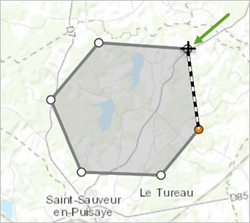

**Tip:** The polygon should be small enough to fit within one Landsat image. It can be of any shape and does not need to be square.

30. Run the cell below to display the coordinates of your polygon.

In [ ]:
# Display the global variable containing the polygon's coordinate information.
geometry_obj

This output can now be reused as an AOI in any workflow. Just copy and paste these few lines into a notebook cell where you want to set up an AOI polygon, as you did at the beginning of this notebook. Assuming you want to put the polygon in a variable named `my_aoi`, add `my_aoi = (` at the beginning, and add a closing parenthesis `)` at the end. It should match the example below. 

`my_aoi = Polygon({'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'rings': [[[359132.9094171927, 6049837.6174895335],
   [359573.1851138971, 6046829.05600958],
   [358130.0536466472, 6045116.867042529],
   [355145.9537419225, 6045214.706345427],
   [354020.80059225933, 6047929.74875035],
   [355806.3707859886, 6050082.215746779],
   [359132.9094171927, 6049837.6174895335]]]})`
   
Then run the cell and use the polygon to select specific Landsat scenes.

You can find other notebooks like this one in the [Analyze imagery with ArcGIS Notebooks](https://learn.arcgis.com/en/paths/analyze-imagery-with-arcgis-notebooks/) learning path. For more information about remote sensing in ArcGIS, see also the [Introduction to Imagery and Remote Sensing](https://introduction-to-remote-sensing-learngis.hub.arcgis.com/) curriculum.

## Acknowledgments <a class="anchor" id="acknowledgments"></a>

Author: Delphine Khanna, principal product engineer at Esri.

Thank you to professor Karen Schuckman, Pennsylvania State University, for her invaluable help. 

If you experience any issues with this notebook, please contact <LearnArcGISSupport@esri.com>.